# The following code is for Geographical Threshold Models

Nodes will be placed randomly in a given Euclidean space, and each node will have a fitness value drawn from some distribution f(x). 

Every pair of N(N-1) nodes will be evaluated to see whether an edge forms, usually as some function of their fitness scores and Euclidean distances apart.

Existing common versions of this model use

(Fitness Distribution) f(x):
* Exponential Distribution
* Power Law
* Uniform on [0, 1]

(Distance Influence) h(r):
* r^-alpha

(Functions of Fitness):
* w + w'
* w * w'

Our novel version will use a normal distribution with mu = 0, sigma = 1, and take |w - w'|h(r) > theta, i.e. the Heavistep function for evaluating if an edge exists between nodes


# Flat version - fitness not a contributing factor

In [5]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections
import seaborn as sns
from scipy.spatial import distance
import powerlaw
import heapq
import os
import gc
import pickle
import math
from sklearn.linear_model import LinearRegression

from base_network_extensions import *

In [33]:
'''
Evaluate fitness edges with vectorized functions
'''

def pbc_distances(coordinates, coordinates_2, dimensions):
    '''
    Calculated the periodic boundary condition distances given coordinates and dimensions of space
    Coordinates need to be passed in an (n, d) numpy array 
    params:
        coordinates, coordinates_2: two sets of coordinates to use in calculation
    return:
        distances - distances given in a n x n numpy array, where distances[i][j] is the pbc
            distance between points i and j
    '''
    num_dim = coordinates.shape[1]
    num_coords = coordinates.shape[0]
    delta_blocks = []
    
    for d in range(num_dim):
        coordinate_block = coordinates.T[d]
        coordinate_block_2 = coordinates_2.T[d]
        dimension = dimensions[d]
        
        delta = np.abs(coordinate_block.reshape(num_coords, 1) - coordinate_block_2)
        delta = np.triu(delta)
        for i in range(delta.shape[0]):
            for j in range(delta.shape[1]):
                if(delta[i][j] > 0.5 * dimension):
                    delta[i][j] = dimension - delta[i][j]
        #delta = np.where(delta > 0.5 * dimension, dimension - delta, delta)
        delta_blocks.append(delta ** 2)
    
    distances = np.sqrt(np.sum(delta_blocks, axis=0))
    return distances
    
    

def add_vectorized_eval_edges(G, dimensions=[1, 1], threshold=0.05, beta=-1.5, keep_edge_distances=False):
    '''
    Add edges between each pair of nodes in a simple spatial graph with normally distributed fitness values
    Assumes that number of nodes is a multiple of 500
    
    params:
        threshold: Heavistep threshold for edge to form
        beta: Power factor for distance
        c: scalar for distance (NOTE: removed this parameter as it is absorbed by threshold)
        keep_edge_distances: boolean that will store edge distances as edge attributes. Increases memory usage for
            the graph, but necessary for closeness centrality calculation
    '''
    coordinates = []
    fitnesses = []
    for i in G.node:
        coordinates.append(G.node[i]['coordinate'])
        fitnesses.append(G.node[i]['fitness'])
    
    coordinates = np.array(coordinates)
    fitnesses = np.array(fitnesses)
    
    #Run node evaluations in groups of 500
    '''
    num_blocks = G.node_count // 500
    remainder = 500
    if(G.node_count / 500 > num_blocks):
        remainder = G.node_count - (500 * num_blocks)
        num_blocks = num_blocks + 1
        
    for i in range(num_blocks):
        for j in range(i, num_blocks):
            i_start = i * 500
            j_start = j * 500
            i_end = (i+1) * 500
            j_end = (j+1) * 500
            if(i == num_blocks - 1):
                i_end = i * 500 + remainder
            if(j == num_blocks - 1):
                j_end = j * 500 + remainder
            coords_i = coordinates[i_start:i_end]
            coords_j = coordinates[j_start:j_end]
            fitnesses_i = fitnesses[i_start:i_end]
            fitnesses_j = fitnesses[j_start:j_end]
            
            fitness_evals = np.abs(fitnesses_i.reshape(i_end - i_start, 1) - fitnesses_j)
            distances = pbc_distances(coords_i, coords_j, dimensions)
            
            #distances = np.where(distances > 0, distances ** beta, distances)
            
            #Trying an alternate method where distances are only penalized beyond 1
            distances = np.where(distances > 1, distances ** beta, 1)
    
            scores = fitness_evals * distances
        
            for i_2 in range(i_end - i_start):
                for j_2 in range(j_end - j_start):
                    node_i = (i * 500) + i_2
                    node_j = (j * 500) + j_2
                    if(node_j > node_i and scores[i_2][j_2] > threshold):
                        G.add_edge(node_i, node_j)
    '''
    
    #not breaking up into blocks
    distances = pbc_distances(coordinates, coordinates, dimensions)
    #distances = np.where(distances > 1, distances ** beta, 1)
    distances = distances ** beta
    
    scores = distances
    
    for i in range(G.node_count):
        for j in range(i+1, G.node_count):
            if(scores[i][j] > threshold):
                G.add_edge(i, j)
                G[i][j]['distance'] = distances[i][j]

Wall time: 1.06 s


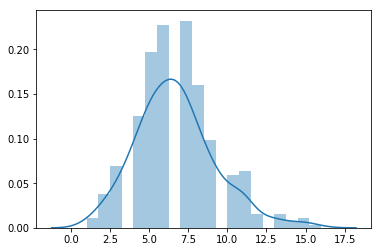

In [14]:
'''
Run simulation for normal_difference_distance_heavistep graph for n nodes
'''
n = 500

g = SimpleSpatialGraph(size=[100, 100])
add_normal_nodes(g, n)
#%time add_eval_edges(g, normal_difference_distance_heavistep)
%time add_vectorized_eval_edges(g, dimensions=[100, 100], threshold=65 )
degrees = graph_degree_distribution(g)

In [15]:
'''
Fitness Evaluation Functions
'''

def normal_difference_heavistep(fitness_i, fitness_j):
  '''
  Expect 2 normally distributed fitnesses
  Check if the absolute difference (distance) between the fitnesses exceeds
  a given threshold
  params:
    fitness_i, fitness_j: fitness values of the two nodes
  TWEAK:
    threshold: value that fitness absolute difference must exceed 
  '''
  threshold = 3.5
  if(abs(fitness_i - fitness_j) > threshold):
    return True
  else:
    return False



def normal_difference_probability(fitness_i, fitness_j):
  '''
  Expect 2 normally distributed fitnesses
  Give absolute difference 
  '''
  pass
  
  

def distance_heavistep(node_i, node_j):
  '''
  Expect 2 node dictionaries that include 'coordinate' keys
  Check if they are close enough (euclidean distance) to form an edge
  params:
    node_i, node_j: dictionary entry of the two nodes (given by G.nodes[i])
  TWEAK:
    threshold: distance that nodes have to be within to form edge
  '''
  threshold = 0.3
  coordinate_i = node_i['coordinate']
  coordinate_j = node_j['coordinate']
  if(distance.euclidean(coordinate_i, coordinate_j) < threshold):
    return True
  else:
    return False
  

def normal_difference_distance_heavistep(node_i, node_j):
  '''
  Expect 2 node dictionaries with both 'coordinate' and 'fitness' keys
  Check if the absolute difference of fitness times a multiplier of 
  distance (euclidean) exceeds a given threshold
  
  |fitness_i - fitness_j| * (dist(i, j))^-a > theta 
  
  params:
    node_i, node_j: dictionary entry of the two nodes (given by G.nodes[i])
  TWEAK:
    threshold: value that fitness times distance modifier must exceed
    alpha: exponent of distance used (will be negative)
  '''
  threshold = 1.5
  alpha = 2
  fitness_i = node_i['fitness']
  fitness_j = node_j['fitness']
  coordinate_i = node_i['coordinate']
  coordinate_j = node_j['coordinate']
  dist = distance.euclidean(coordinate_i, coordinate_j)
  total = (dist ** alpha) * abs(fitness_i - fitness_j)
  if(total > threshold):
    return True
  else:
    return False


def gnp_random(node_i, node_j):
    '''
    Uniformly randomly add edge with probability p
    TWEAK:
        p: probability of adding edge
    '''
    p = 0.05
    if(np.random.uniform() < p):
        return True
    else:
        return False
    
def fully_connected(node_i, node_j):
    '''
    Return True for all edges
    '''
    return True


'''
MODEL GENERATING FUNCTION
This code completes the whole graph generation from initiation to edge evaluation
It is used throughout the rest of the code
'''
all_mean_degree_results = pickle.load(open('mean_degree_beta_threshold_variation_wider.pickle', 'rb'))

def graph_model(n=500, beta=-1.0, size=[100, 100], threshold=False, keep_edge_distances=False):
    '''
    The most important thing to tweak is the threshold
    If no threshold is specified, we will look for the threshold found for n=500 that gives
        mean degree 20
    '''
    if(not threshold):
        threshold = target_thresholds[beta]
    
    g = SimpleSpatialGraph(size=size)
    add_normal_nodes(g, n)

    add_vectorized_eval_edges(g, dimensions=size, threshold=threshold, beta=beta, keep_edge_distances=keep_edge_distances)
    return g

c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in power


LinAlgError: singular matrix

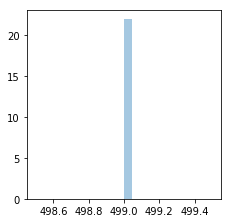

In [35]:
'''
Run simulation for normal_difference_distance_heavistep graph across range of thresholds and betas
'''
n = 500

thresholds = [0.03, 0.1, 0.3, 1.0]
betas = [-0.5, -1, -1.5, -2]

num_plots = len(thresholds) * len(betas)

plt.figure(figsize=(16, 16))

for i in range(len(thresholds)):
    for j in range(len(betas)):
        g = SimpleSpatialGraph(size=[100, 100])
        add_normal_nodes(g, n)

        threshold = thresholds[i]
        beta = betas[j]
        
        add_vectorized_eval_edges(g, dimensions=[100, 100], threshold=threshold, beta=beta)
        degrees = graph_degree_distribution_subplot(g, len(thresholds), len(betas), (i * len(betas))+j+1)

In [46]:
del graphs
gc.collect()

290836

In [26]:
target_thresholds = {}

Parameter set 0
Threshold: 0.0006
Beta: -3.0
Number of nodes: 500


c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in power


Parameter set 0 mean degree: 22.109600
-------------------------------------
Parameter set 1
Threshold: 0.0007
Beta: -3.0
Number of nodes: 500
Parameter set 1 mean degree: 19.874800
-------------------------------------
Parameter set 2
Threshold: 0.0008
Beta: -3.0
Number of nodes: 500
Parameter set 2 mean degree: 18.170800
-------------------------------------
Parameter set 3
Threshold: 0.0009
Beta: -3.0
Number of nodes: 500
Parameter set 3 mean degree: 16.585600
-------------------------------------


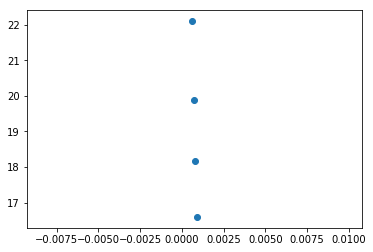

In [74]:
'''
Capture average degree for multiple trials of the given parameters (mean over 10 trials)
Graph dependence of simulations on threshold value
'''
ns = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500]
n = 500
#thresholds=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
thresholds = [0.0006, 0.0007, 0.0008, 0.0009]
#thresholds = [10, 20, 30, 40, 50, 60, 70, 80]
#thresholds = [0.28, 0.29, 0.30, 0.31, 0.32]
#threshold = all_mean_degree_results['target2.5']
beta = -3.0
num_trials = 10

degree_results = []
mean_degree_results = []
all_threshold_graphs = {}

#for i in range(len(thresholds)):
for i in range(len(thresholds)):
    threshold_graphs = []
    
    print('Parameter set %(num)d' % {'num': i})
    
    #uncomment the parameters wanted to shift per set
    threshold = thresholds[i]
    #n = ns[i]
    
    print('Threshold: %(threshold)s' % {'threshold': threshold})
    print('Beta: %(beta)s' % {'beta': beta})
    print('Number of nodes: %(n)s' % {'n': n})
    
    degrees = 0
    
    for j in range(num_trials):
        g = SimpleSpatialGraph(size=[100, 100])
        add_normal_nodes(g, n)

        add_vectorized_eval_edges(g, dimensions=[100, 100], threshold=threshold, beta=beta)
        mean_degree = average_degree(g)
        degree_results.append(mean_degree)
        
        #note this mean_degree is the mean_degree of the network, so to get the average degree
        #over n trials, we add all the mean degrees in each trial and divide by n
        
        degrees += mean_degree
        #print('Trial %(num)d mean degree: %(mean_degree)f' % {'num': j, 'mean_degree': mean_degree})
        #threshold_graphs.append(g)
        
    mean_degree_results.append(degrees / num_trials)
    mean_degree = degrees / num_trials
    #all_threshold_graphs[threshold] = threshold_graphs
    print('Parameter set %(num)d mean degree: %(mean_degree)f' % {'num': i, 'mean_degree': mean_degree})
    print('-------------------------------------')
    

#graph the results for change in threshold
plt.scatter(thresholds, mean_degree_results)
#plt.scatter(ns, mean_degree_results)
#pickle.dump(all_threshold_graphs, open("beta-2.5_threshold_spread_graphs.pickle", 'wb'))


In [71]:
beta_30_mean_degree_results = mean_degree_results

In [72]:
all_mean_degree_results = {
    'description': "With 500 nodes and 5 trials, we tested to see how mean degree would vary by threshold and beta value",
    'thresholds': thresholds,
    -0.5: beta_05_mean_degree_results,
    -1.0: beta_10_mean_degree_results,
    -1.5: beta_15_mean_degree_results,
    -2.0: beta_20_mean_degree_results,
    -2.5: beta_25_mean_degree_results,
    -3.0: beta_30_mean_degree_results
}
'''all_mean_degree_results = {
    'description': "With 500 nodes and 5 trials, we tested to see how mean degree would vary by threshold and beta value, over larger range",
    'thresholds': thresholds,
    'beta=-0.5': beta_05_mean_degree_results,
    'beta=-1.0': beta_10_mean_degree_results,
    'beta=-1.5': beta_15_mean_degree_results,
    'beta=-2.0': beta_20_mean_degree_results,
    'beta=-2.5': beta_25_mean_degree_results,
    'beta=-3.0': beta_30_mean_degree_results
}'''
'''all_ns_mean_degree_results = {
    'description': "Using threshold where beta results in mean degree of 20 at n=500, vary number of nodes",
    'thresholds': thresholds,
    'beta=-0.5': ns_05_mean_degree_results,
    'beta=-1.0': ns_10_mean_degree_results,
    'beta=-1.5': ns_15_mean_degree_results,
    'beta=-2.0': ns_20_mean_degree_results,
    'beta=-2.5': ns_25_mean_degree_results,
    'beta=-3.0': ns_30_mean_degree_results
}'''
pickle.dump(all_mean_degree_results, open("mean_degree_beta_threshold_variation_flat.pickle", 'wb'))

ValueError: x and y must be the same size

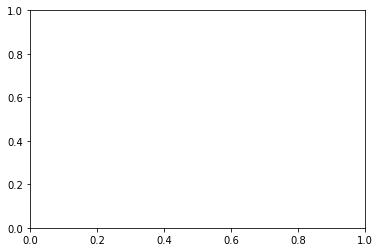

In [73]:
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_05_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_10_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_15_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_20_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_25_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_30_mean_degree_results)))
plt.xlabel('log2 threshold')
plt.ylabel('log2 mean degree')

In [ ]:
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_05_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_10_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_15_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_20_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_25_mean_degree_results)))
plt.scatter(np.log2(thresholds), np.log2(np.array(beta_30_mean_degree_results)))
plt.xlabel('log2 threshold')
plt.ylabel('log2 mean degree')

This is even more visible in the log plots. from beta=-1.5 on, there seems to be straight line power lines we can draw, whereas a powerlaw doesn't even seem respected from beta=-0.5 and beta=-1.0

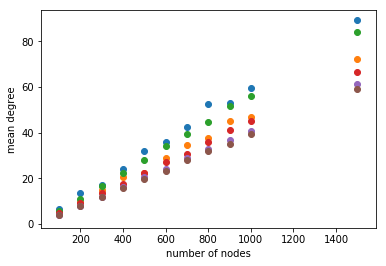

In [235]:
plt.scatter(ns, ns_05_mean_degree_results)
plt.scatter(ns, ns_10_mean_degree_results)
plt.scatter(ns, ns_15_mean_degree_results)
plt.scatter(ns, ns_20_mean_degree_results)
plt.scatter(ns, ns_25_mean_degree_results)
plt.scatter(ns, ns_30_mean_degree_results)
plt.xlabel('number of nodes')
plt.ylabel('mean degree')

After controlling the threshold such that each of the betas has ~20 mean degree at 500 nodes, we vary the number of nodes and see a linear relationship. This kind of makes sense as the number of nodes heuristically is modifying the potential number of edges per node in a given radius/fitness combination. 

Since the change in mean degree is non-linear with respect to differing thresholds, it would difficult to modify the threshold and number of nodes simultaneously to retain a specific mean degree

0.00070541694025
The target value for threshold is 1.00048907732


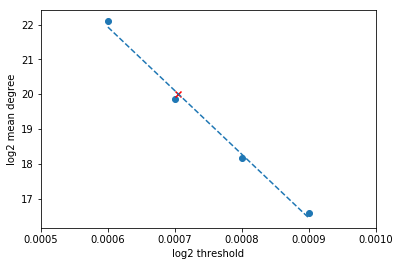

In [76]:
#X = thresholds_np[-3:].reshape(-1, 1)
#y = beta_05_mean_degree_results[-3:]
#thresholds = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
X = np.array(thresholds).reshape(-1, 1)
y = mean_degree_results

target_k = 20
target_log_k = math.log2(target_k)

regressor = LinearRegression()
#regressor.fit(np.log2(X), np.log2(np.array(y)))
#plt.scatter(np.log2(X), np.log2(y))
regressor.fit(X, y)
plt.scatter(X, y)

#line_x = np.linspace(np.log2(X)[0], np.log2(X)[-1], 10)
line_x = np.linspace(X[0], X[-1], 10)
line_y = line_x * regressor.coef_[0] + regressor.intercept_
plt.plot(line_x, line_y, '--')
plt.xlim([X[0] - 0.0001, X[-1] + 0.0001])
target_x = (target_k - regressor.intercept_) / regressor.coef_[0]
plt.scatter([target_x], regressor.predict(target_x), color='red', marker='x')
print(target_x)
print('The target value for threshold is %(threshold)s' % {'threshold': 2 ** target_x})
plt.xlabel('log2 threshold')
plt.ylabel('log2 mean degree')

#plt.savefig('beta-0.5 w2 threshold-k plot.png')

In [77]:
print(len(beta_25_mean_degree_results))
print(len(thresholds))

10
5


In [77]:
target_thresholds[-3.0] = target_x
print(target_x)

0.00070541694025


In [80]:
target_thresholds[-2.5] = 2 ** target_x
print(2 ** target_x)

0.000540250960257


{-0.5: 0.29779916629952213, -1.0: 0.089923117572090233, -1.5: 0.026342724921736765, -2.0: 0.0078995770227861944, -2.5: 0.0023413388986996304, -3.0: 0.00070541694024950775, -2.25: 0.0043136267023084537, -2.1: 0.0062028069936189839, -1.95: 0.0089193658272512626, -1.9: 0.010067366512976114, -1.85: 0.011363124965334788, -1.8: 0.012825658906069196, -1.75: 0.014476433804667344, -1.7: 0.016339677924987285, -1.65: 0.018442737921147281, -1.6: 0.020816480201728847, -1.55: 0.023495743953076416, -1.4: 0.033785854681034469, -1.25: 0.048582584948476101}


'\nNote to be very careful - our range of interest is around -2.0 - -1.5 but this seems to be exactly \nwhere the threshold is a little different\n'

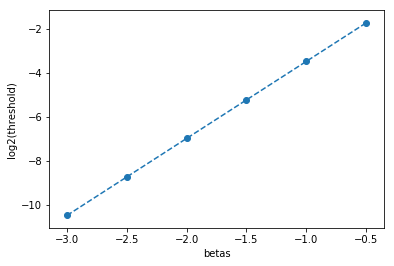

In [78]:
'''
Block of code for getting thresholds for target betas at n=500 nodes based on previous betas
Interestingly, though the thresholds seem to follow a very consistent power law, the qualitative behavior of the
    networks changes
'''

betas = [-0.5, -1.0, -1.5, -2.0, -2.5, -3.0]
thresholds = []

#Mark target_betas here
target_betas = [-2.25, -2.10, -1.95, -1.90, -1.85, -1.80, -1.75, -1.70, -1.65, -1.60, -1.55, -1.40, -1.25]
#target_thresholds = {}

for beta in betas:
#    target_string = 'target' + str(beta).split('-')[1]
#    thresholds.append(all_mean_degree_results[target_string])
    thresholds.append(target_thresholds[beta])
#    target_thresholds[beta] = all_mean_degree_results[target_string]
#plt.scatter(betas, np.log2(thresholds))

regressor = LinearRegression()
regressor.fit(np.array(betas).reshape(-1, 1), np.log2(thresholds))

line_x = np.linspace(betas[0], betas[-1], 10)
line_y = line_x * regressor.coef_[0] + regressor.intercept_
plt.plot(line_x, line_y, '--')

plt.scatter(betas, np.log2(thresholds))

plt.xlabel('betas')
plt.ylabel('log2(threshold)')

for beta in target_betas:
    threshold = 2 ** regressor.predict(beta)
    target_thresholds[beta] = threshold[0]
print(target_thresholds)
#print(all_mean_degree_results['target2.0'])
#print(all_mean_degree_results['target1.5'])

'''
Note to be very careful - our range of interest is around -2.0 - -1.5 but this seems to be exactly 
where the threshold is a little different
'''

c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in power
c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in reciprocal


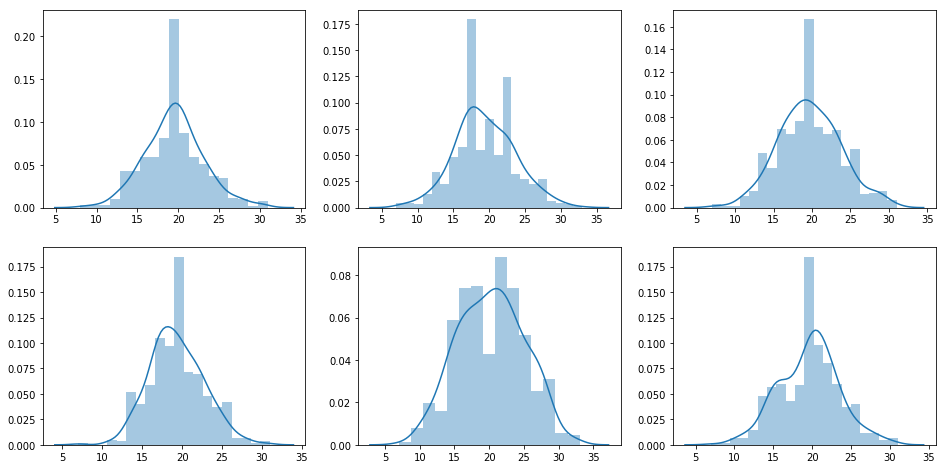

In [80]:
'''
Run simulation for normal_difference_distance_heavistep graph across range of thresholds and betas
'''
n = 500

thresholds = []
betas = [-0.5, -1, -1.5, -2, -2.5, -3.0]
for beta in betas:
    thresholds.append(target_thresholds[beta])

num_plots = 6

plt.figure(figsize=(16, 8))

for i in range(num_plots):
    g = SimpleSpatialGraph(size=[100, 100])
    add_normal_nodes(g, n)

    threshold = thresholds[i]
    beta = betas[i]

    add_vectorized_eval_edges(g, dimensions=[100, 100], threshold=threshold, beta=beta)
    degrees = graph_degree_distribution_subplot(g, 2, 3, i+1)

In the above graphs, we have controlled for n (500) and the mean degree (~20), but notice that there are qualitative differences between the degree distributions of the graphs. A power law is only really respected in the case of beta=-0.5. Also since the mean degree is being controlled, the median degree increases with higher beta cost... interesting.

In [81]:
'''
Create graphs to analyze
'''
all_mean_degree_results = pickle.load(open('mean_degree_beta_threshold_variation_wider.pickle', 'rb'))

num_graphs = 10
n = 500

graphs = {}
betas = [-0.5, -1.0, -1.5, -2.0, -2.5, -3.0]
new_betas = [-1.95, -1.90, -1.85, -1.80, -1.75, -1.70, -1.65, -1.60, -1.55]


for beta in betas:
    beta_array = []
    #target_string = 'target' + str(beta).split('-')[1]
    #threshold = all_mean_degree_results[target_string]
    
    threshold = target_thresholds[beta]
    
    for i in range(num_graphs):
        g = SimpleSpatialGraph(size=[100, 100])
        add_normal_nodes(g, 500)
        add_vectorized_eval_edges(g, dimensions=[100, 100], threshold=threshold, beta=beta)
        beta_array.append(g)
    graphs[str(beta)] = beta_array
    print("Beta %(beta)s completed" % {'beta': str(beta)})
        
#pickle.dump(graphs, open("n500graphs_flat.pickle", 'wb'))

c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in power


Beta -0.5 completed


c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in reciprocal


Beta -1.0 completed
Beta -1.5 completed
Beta -2.0 completed
Beta -2.5 completed
Beta -3.0 completed


In [82]:
new_betas = [-1.95, -1.90, -1.85, -1.80, -1.75, -1.70, -1.65, -1.60, -1.55]

target_thresholds_2 = target_thresholds.copy()
for beta in new_betas:
    del target_thresholds[beta]
    

In [88]:
del target_thresholds[-2.25]
del target_thresholds[-2.1]
del target_thresholds[-1.4]
del target_thresholds[-1.25]

In [84]:
print(target_thresholds_2)
pickle.dump(target_thresholds_2, open("target_thresholds_flat.pickle", 'wb'))

{-0.5: 0.29779916629952213, -1.0: 0.089923117572090233, -1.5: 0.026342724921736765, -2.0: 0.0078995770227861944, -2.5: 0.0023413388986996304, -3.0: 0.00070541694024950775, -2.25: 0.0043136267023084537, -2.1: 0.0062028069936189839, -1.95: 0.0089193658272512626, -1.9: 0.010067366512976114, -1.85: 0.011363124965334788, -1.8: 0.012825658906069196, -1.75: 0.014476433804667344, -1.7: 0.016339677924987285, -1.65: 0.018442737921147281, -1.6: 0.020816480201728847, -1.55: 0.023495743953076416, -1.4: 0.033785854681034469, -1.25: 0.048582584948476101}


In [17]:
'''
Load graphs and target_thresholds
'''
target_thresholds = pickle.load(open("target_thresholds_flat.pickle", 'rb'))
graphs = pickle.load(open("n500graphs_flat.pickle", 'rb'))

In [91]:
#Generic code for analyzing graphs
#Run the previous block to create the dictionary
def analyze_graphs_with_function(func_type, verbose=0, xlabel=False, ylabel=False):
    '''
    Analyze the set of graphs using the given func_type
    params:
        func_type: one of predetermined strings:
            'degree_assortativity'
            'fitness_assortativity' (fitness assortativity coefficient)
            'laplacian_spectrum' (value of the second eigenvalue)
            'clustering'
            'geodesic'
            'mean_degree'
        verbose:
            0: only print betas in line
            1: print per beta
            2: print per trial
    '''
    
    betas = []
    for beta in target_thresholds:
        betas.append(beta)
    all_avg_values = []
    all_betas = []
    all_values = []
    
    for i, beta in enumerate(betas):
        if(verbose == 0):
            print(beta, end=', ')
        if(verbose > 0):
            print('Set %(set_num)d analysis: beta = %(beta)f' % {'beta': beta, 'set_num': i})
        graph_array = graphs[str(beta)]
        value_sum = 0
        for j, graph in enumerate(graph_array):
            if(func_type == 'degree_assortativity'):
                value = nx.degree_assortativity_coefficient(graph)
            elif(func_type == 'fitness_assortativity'):
                value = nx.attribute_assortativity_coefficient(graph, 'fitness')
            elif(func_type == 'laplacian_spectrum'):
                value = nx.laplacian_spectrum(graph)[1]
            elif(func_type == 'clustering'):
                value = nx.average_clustering(graph)
            elif(func_type == 'geodesic'):
                try:
                    value = nx.average_shortest_path_length(graph)
                except Exception as e:
                    print('Exception raised, graph likely not connected. \
                    Trial %(trial_num)d, beta = %(beta)f' % {'beta': beta, 'trial_num': j})
            elif(func_type == 'mean_degree'):
                value = average_degree(graph)
            else:
                print('Function type not recognized')
                return
            all_values.append(value)
            all_betas.append(beta)
            value_sum += value
            if(verbose > 1):
                print('Trial %(trial_num)d: value = %(value)f' % {'trial_num': j, 'value': value})
        
        avg_value = value_sum / len(graph_array)
        if(verbose > 0):
            print('Set complete, average value = %(avg_value)f' % {'avg_value': avg_value})
            print('-----------------------')
        all_avg_values.append(avg_value)
    plt.scatter(betas, all_avg_values)
    plt.scatter(all_betas, all_values, alpha=0.2)
        
        
        
def plot_graph_character_correlation(centrality1=False, centrality2=False):
    '''
    Plot the correlations between main graph values - will plot a grid of correlations,
    each plot will be ordered by the value on the x-axis
    Returns the calculated centralities dictionary
    '''
    centralities = {
    }
    
    def for_all_graphs(func_type):
        values = []
        for beta in graphs:
            for graph in graphs[str(beta)]:
                if(func_type == 'degree_assortativity'):
                    value = nx.degree_assortativity_coefficient(graph)
                elif(func_type == 'fitness_assortativity'):
                    value = nx.attribute_assortativity_coefficient(graph, 'fitness')
                elif(func_type == 'laplacian_spectrum'):
                    value = nx.laplacian_spectrum(graph)[1]
                elif(func_type == 'clustering'):
                    value = nx.average_clustering(graph)
                elif(func_type == 'geodesic'):
                    value = nx.average_shortest_path_length(graph)
                elif(func_type == 'mean_degree'):
                    value = average_degree(graph)
                values.append(value)
        return values
    
    print('Gathering degree and betas')
    all_betas = []
    all_mean_degree = []
    for beta in graphs:
        for graph in graphs[str(beta)]:
            all_betas.append(beta)
            all_mean_degree.append(average_degree(graph))
    centralities['Beta'] = all_betas
    centralities['Mean Degree'] = all_mean_degree
    
    
    centrality_types = {
        'degree_assortativity': 'Degree Assortativity',
       'laplacian_spectrum': '2nd Eigenvalue',
       'clustering': 'Clustering',
       'geodesic': 'Mean Geodesic Distance'
    }
    
    for func_type in centrality_types:
        name = centrality_types[func_type]
        print('calculating values for ' + name)
        values = for_all_graphs(func_type)
        centralities[name] = values
    
    print('Plotting graphs')
    plt.figure(figsize=(16, 16))
    #plt.tight_layout()
     
    for i, key1 in enumerate(centralities):
        #key1 will be the y-axis
        for j, key2 in enumerate(centralities):
            plt.subplot(len(centralities), len(centralities), i * len(centralities) + j + 1)
            #plot histogram along diagonal
            if(i == j):
                pass
            else:
                x = centralities[key2]
                y = centralities[key1]
                plt.scatter(x, y, alpha=0.4)
                plt.xlabel(key2)
                plt.ylabel(key1)
    
    plt.tight_layout()
    return centralities

Gathering degree and betas
calculating values for Degree Assortativity
calculating values for 2nd Eigenvalue
calculating values for Clustering
calculating values for Mean Geodesic Distance
Plotting graphs


{'2nd Eigenvalue': [1.9746016747811448,
  0.99680681011180439,
  1.9888363418496124,
  2.9508637179767794,
  4.9629662739818921,
  2.9541142315303901,
  0.98447820063963187,
  2.9465091671357606,
  5.9070871692249014,
  2.9478805052807706,
  3.8343151276102527,
  3.0905441672537108,
  2.9496796823955811,
  2.4084717546467478,
  3.5944291970614994,
  2.4552195561033234,
  2.7737316479878187,
  2.5907098811619544,
  3.6766134014759437,
  2.4199941837979724,
  1.7972193446531814,
  1.9645120801681681,
  1.9342695097277003,
  2.202204505346943,
  1.9608003587007741,
  1.693199179195926,
  1.9877362677952233,
  1.9258428259836222,
  2.0572288116784598,
  2.1893092135367969,
  1.4951009638020931,
  1.751772282486765,
  1.7363977054694757,
  1.4042956984441319,
  1.4781207280276902,
  1.7153629774385522,
  1.709256359891673,
  1.4684082544576882,
  1.6857021533496166,
  1.4429757119507454,
  1.2250090736887549,
  1.1924094388891007,
  1.3058569901898778,
  1.1697972309545752,
  1.227004114572

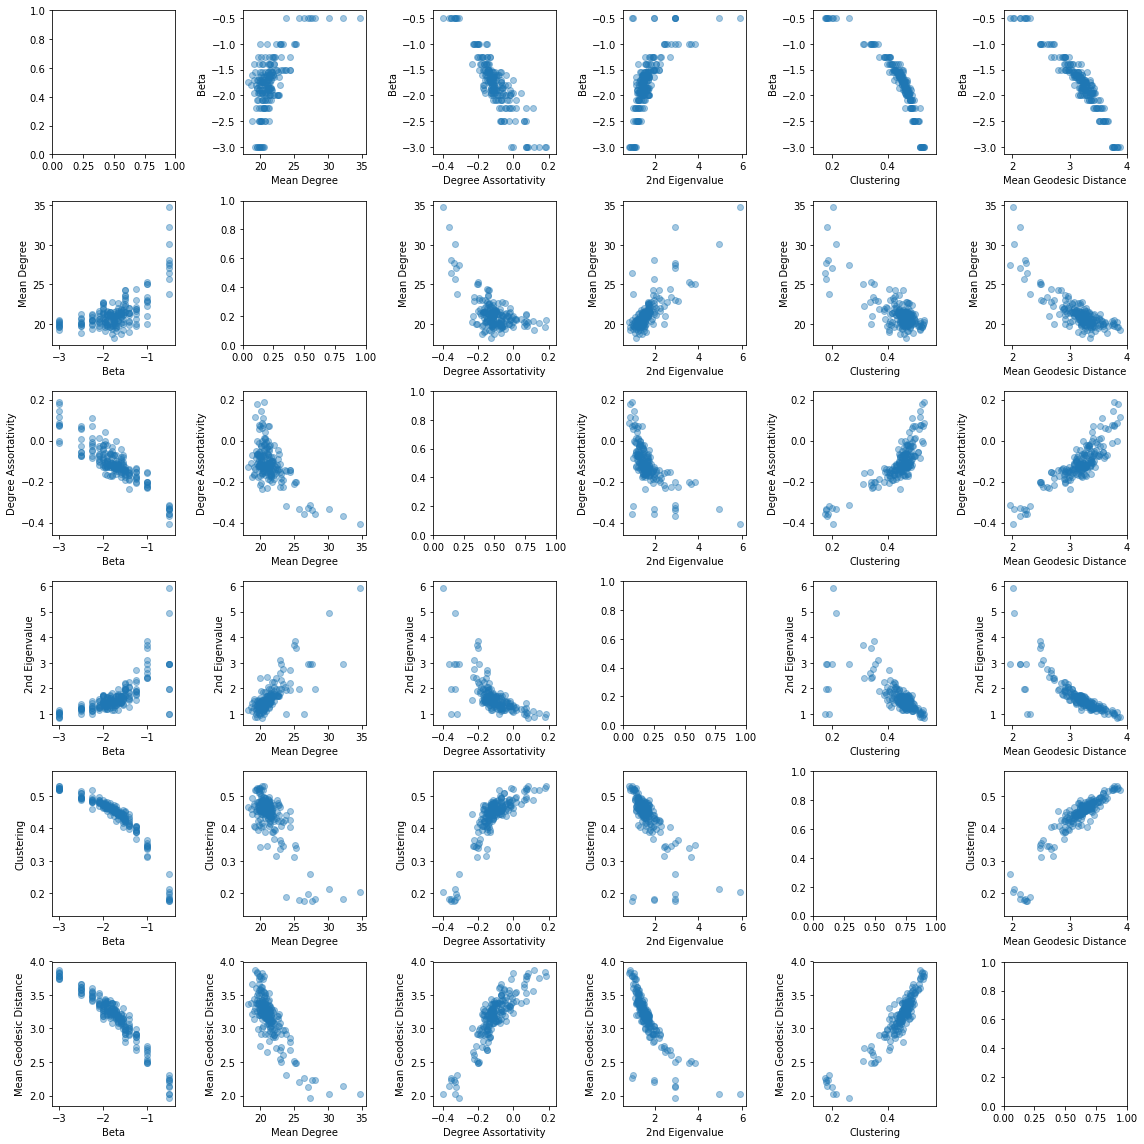

In [226]:
centralities = plot_graph_character_correlation()

-0.5, -1.0, -1.5, -2.0, -2.5, -3.0, 

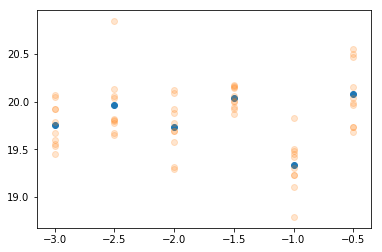

In [92]:
analyze_graphs_with_function('mean_degree', False)

-0.5, -1.0, -1.5, -2.0, -2.5, -3.0, 

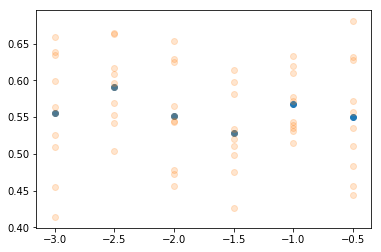

In [93]:
analyze_graphs_with_function('degree_assortativity', False)

-0.5, -1.0, -1.5, -2.0, -2.5, -3.0, 

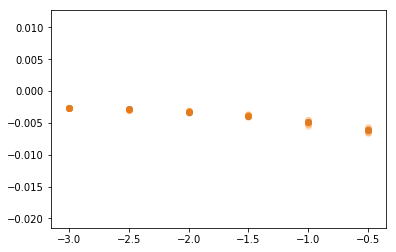

In [95]:
analyze_graphs_with_function('fitness_assortativity', False)

-0.5, -1.0, -1.5, -2.0, -2.5, -3.0, 

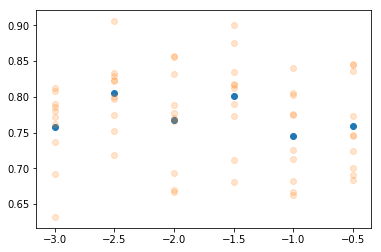

In [94]:
analyze_graphs_with_function('laplacian_spectrum', False)

-0.5, -1.0, -1.5, -2.0, -2.5, -3.0, 

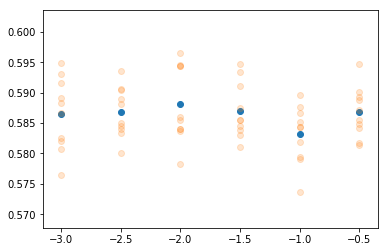

In [95]:
analyze_graphs_with_function('clustering', False)

-0.5, -1.0, -1.5, -2.0, -2.5, -3.0, 

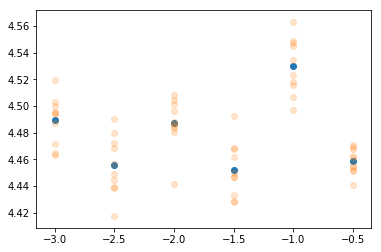

In [96]:
analyze_graphs_with_function('geodesic', False)

### Next ideas for things to think about

Centralities are per node. Some analysis can be conducted qualitatively, but without a real spatial embedding (e.g. a map that the points lie on), we may only expect to see some things like how correlated the centrality is to barycenters of the graph, or whether the centralities tend to cluster. It may be additionally useful to look at centrality correlates with degree, clustering, other centralities, etc.

Interesting note about the betweenness centrality: looks to be correlated with points that are not closely clustered to others (lower closeness centrality) - may be because they are more important for connecting distal nodes, whereas clustered nodes have more path options to choose from

Use a lattice for further comparison to remove an aspect of randomness from experiments

Average edge length to degree correlation

Closeness centrality as closeness in physical space to other points, or as closeness in network distance

Maybe it is useful to look at some motivating examples. Look for examples where:
* Need to not have planar limitation
* Likely to have a component of randomness in terms of "goodness of connector"
* Natural "fitness" analog could be useful

Ideas:
* Air traffic networks
* Brain networks
* Social network embedded in latent space

Other ways to apply the normal fitness distribution:
* |w + w'| = "compatibility"
* w * w' = "multiplicative compatibility"
* + c = "free added fitness"

In [97]:
def graph_spatial_network_plot_valued(G, values=False, graph_edges=False, highlight_edges=False):
  '''
  Create a plot showing what a 2D spatial graph looks like, coloring by passed values and sized by degree
  params:
    G: passed in SimpleSpatialGraph
    values: values according to the labels of the nodes
    graph_edges: graph edges as well (this function takes into account periodic boundary conditions)
    highlight_edges: Optionally parameter to draw in specific edges highlighted, will 
        also highlight the latest node
  '''
  X = []
  Y = []
  degrees = []
  scatter_values = []
  
  plt.figure(figsize=(16, 16))
  for i in list(G.nodes):
    coordinate = G.nodes[i]['coordinate']
    X.append(coordinate[0])
    Y.append(coordinate[1])
    degrees.append(G.degree[i])
    scatter_values.append(values[i])
  
  if(graph_edges):
    for i in G.edges:
      coordinate_i = G.nodes[i[0]]['coordinate']
      coordinate_j = G.nodes[i[1]]['coordinate']
      points = False
      if(abs(coordinate_i[0] - coordinate_j[0]) > G.size[0] / 2 and
          abs(coordinate_i[1] - coordinate_j[1]) > G.size[0] / 2):
        max_x = max(coordinate_i[0], coordinate_j[0])
        max_y = max(coordinate_i[1], coordinate_j[1])
        min_x = min(coordinate_i[0], coordinate_j[0])
        min_y = min(coordinate_i[1], coordinate_j[1])
        x1 = (max_x, max_x + 50)
        x2 = (min_x, min_x - 50)
        y1 = (max_y, max_y + 50)
        y2 = (min_y, min_y - 50)
        points = (x1, x2, y1, y2)
      elif(abs(coordinate_i[0] - coordinate_j[0]) > G.size[0] / 2):
        coordinates = sorted([[coordinate_i[0], coordinate_i[1]], 
          [coordinate_j[0], coordinate_j[1]]])
        x1 = (coordinates[1][0], coordinates[1][0] + 50)
        x2 = (coordinates[0][0], coordinates[0][0] - 50)
        y1 = (coordinates[1][1], coordinates[0][1])
        y2 = (coordinates[0][1], coordinates[1][1])
        points = (x1, x2, y1, y2)
      elif(abs(coordinate_i[1] - coordinate_j[1]) > G.size[0] / 2):
        coordinates = sorted([[coordinate_i[1], coordinate_i[0]], 
          [coordinate_j[1], coordinate_j[0]]])
        y1 = (coordinates[1][0], coordinates[1][0] + 50)
        y2 = (coordinates[0][0], coordinates[0][0] - 50)
        x1 = (coordinates[1][1], coordinates[0][1])
        x2 = (coordinates[0][1], coordinates[1][1])
        points = (x1, x2, y1, y2)

      if(points):
        plt.plot(points[0], points[2], alpha=0.2, color='grey')
        plt.plot(points[1], points[3], alpha=0.2, color='grey')
      else:
        x = (coordinate_i[0], coordinate_j[0])
        y = (coordinate_i[1], coordinate_j[1])
        plt.plot(x, y, alpha=0.2, color='grey')

  if(highlight_edges):
    for i in highlight_edges:
      coordinate_i = G.nodes[i[0]]['coordinate']
      coordinate_j = G.nodes[i[1]]['coordinate']
      x = (coordinate_i[0], coordinate_j[0])
      y = (coordinate_i[1], coordinate_j[1])
      plt.plot(x, y, alpha=0.2, color='red')

  plt.scatter(X, Y, c=scatter_values, s=degrees, cmap='viridis')
  plt.colorbar()

  if(highlight_edges):
    node = G.nodes[len(G.nodes) - 1]
    x = [node['coordinate'][0]]
    y = [node['coordinate'][1]]
    plt.scatter(x, y, c='red')

  plt.xlim([0, G.size[0]])
  plt.ylim([0, G.size[1]])
    

def plot_centrality_correlation(G, centrality1=False, centrality2=False):
    '''
    Plot the correlations between centralities - will plot a grid of correlations,
    each plot will be ordered by the value on the x-axis
    Returns the calculated centralities dictionary
    '''
    centralities = {
        'Degree': G.degree
    }
    sorting_dict = {}
    print('Calculating betweenness')
    centralities['Betweenness'] = nx.betweenness_centrality(g)
    print('Calculating closeness')
    centralities['Closeness'] = nx.closeness_centrality(g)
    print('Gathering fitnesses')
    fitnesses = {}
    for i in range(G.node_count):
        fitnesses[i] = G.node[i]['fitness']
    centralities['Fitness'] = fitnesses
    
    print('Plotting graphs')
    plt.figure(figsize=(16, 16))
    #plt.tight_layout()
    
    for i in range(G.node_count):
        sorting_dict[i] = {}
        for key in centralities:
            sorting_dict[i][key] = centralities[key][i]
    
    for i, key1 in enumerate(centralities):
        #key1 will be the y-axis
        for j, key2 in enumerate(centralities):
            plt.subplot(len(centralities), len(centralities), i * len(centralities) + j + 1)
            #plot histogram along diagonal
            if(i == j):
                hist_values = []
                for k in range(G.node_count):
                    hist_values.append(centralities[key1][k])
                sns.distplot(hist_values)
                plt.xlabel(key1)
                plt.ylabel('Proportion')
            else:
                sorted_keys = sorted(sorting_dict, key=lambda x: (sorting_dict[x][key2], sorting_dict[x][key1]))
                x = []
                y = []
                for k in range(G.node_count):
                    x.append(centralities[key2][sorted_keys[k]])
                    y.append(centralities[key1][sorted_keys[k]])
                plt.scatter(x, y, alpha=0.4)
                plt.xlabel(key2)
                plt.ylabel(key1)
    
    plt.tight_layout()
    return centralities

In [100]:
g = graph_model(beta=-1.5)
betw = nx.betweenness_centrality(g)
print(average_degree(g))

c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in power


20.12


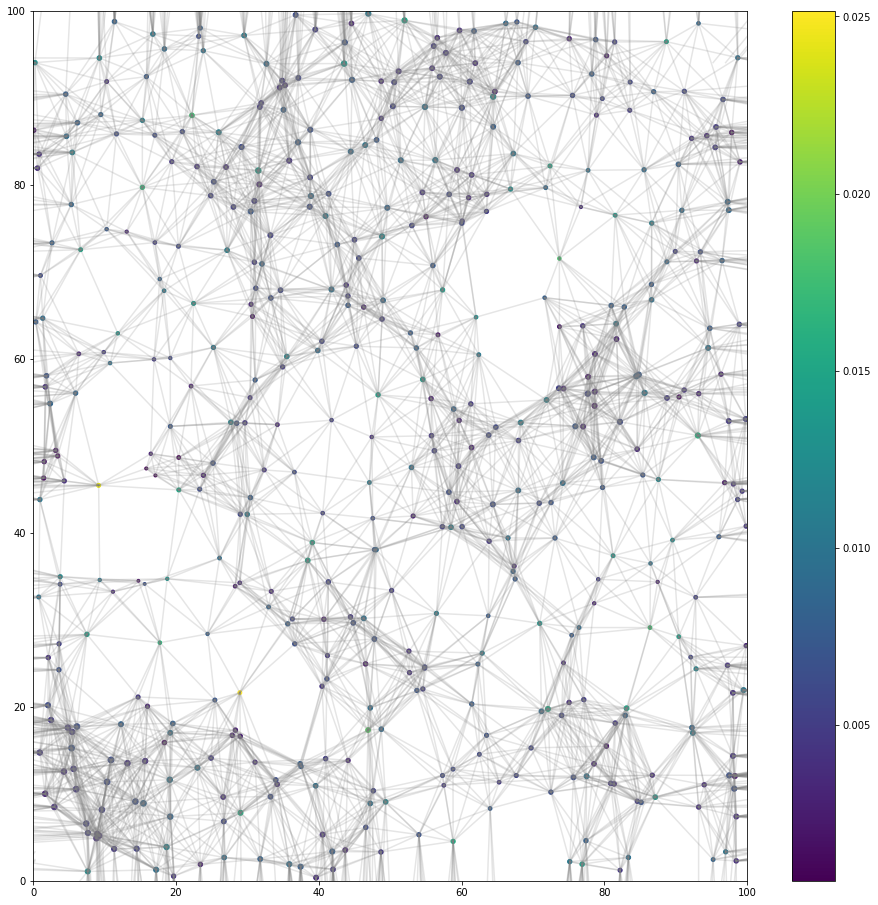

In [101]:
#beta = -1.5
graph_spatial_network_plot_valued(g, betw, True)

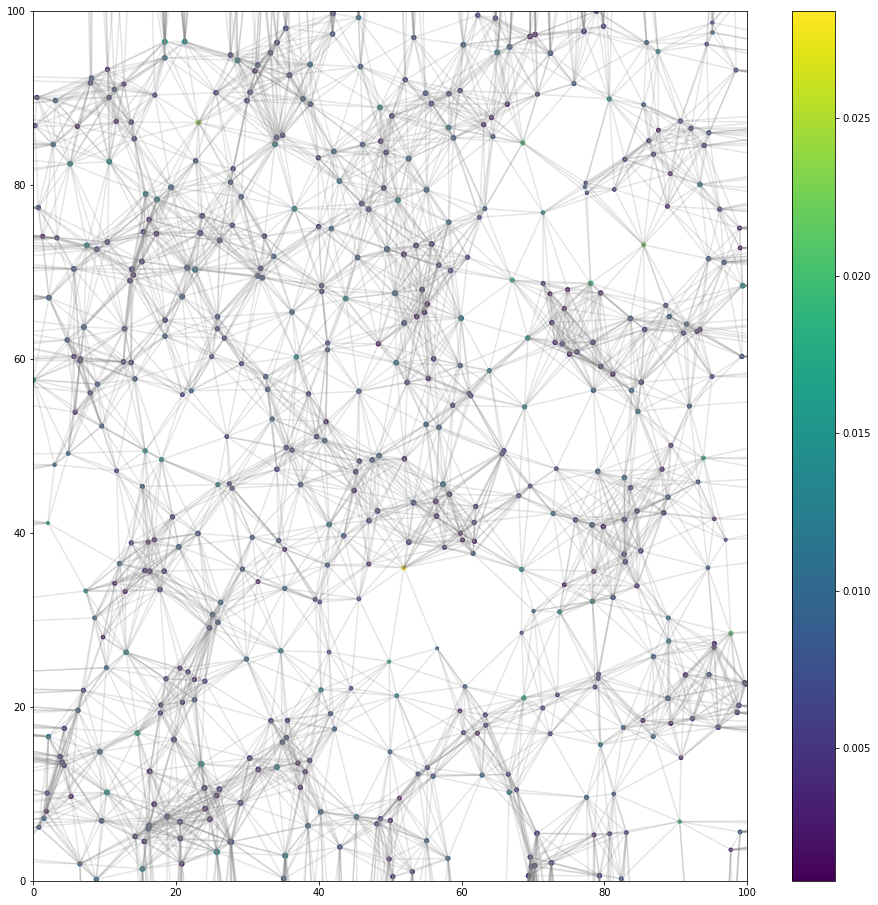

In [99]:
#beta = -3.0
graph_spatial_network_plot_valued(g, betw, True)

In [63]:
comb_values = dict()
for i in range(500):
    comb_values[i] = {'degree': g.degree[i], 'betweenness': betw[i]}

In [113]:
#sorted_values = sorted(g.degree, key=lambda x: g.degree[x])
sorted_values = sorted(comb_values, key=lambda x: (comb_values[x]['degree']))
#for i in range(5):
#    print(sorted_values[i])
for i in range(500):
    print(comb_values[sorted_values[i]])

{'degree': 8, 'betweenness': 0.001245482186016402}
{'degree': 8, 'betweenness': 0.00616191968828512}
{'degree': 8, 'betweenness': 0.00039974841344913014}
{'degree': 8, 'betweenness': 0.00045037291486216117}
{'degree': 8, 'betweenness': 0.0011412332667316268}
{'degree': 9, 'betweenness': 0.0013154685414443386}
{'degree': 9, 'betweenness': 0.0024925254829473507}
{'degree': 9, 'betweenness': 0.0017990063945758882}
{'degree': 9, 'betweenness': 0.0015316511338515676}
{'degree': 9, 'betweenness': 0.0012839256759473372}
{'degree': 10, 'betweenness': 0.0007355360711676009}
{'degree': 10, 'betweenness': 0.0007916947026411775}
{'degree': 10, 'betweenness': 0.001722750790361934}
{'degree': 10, 'betweenness': 0.0001729863842375755}
{'degree': 10, 'betweenness': 0.002027017594551656}
{'degree': 10, 'betweenness': 0.0006278161991535921}
{'degree': 10, 'betweenness': 0.000745639654914767}
{'degree': 10, 'betweenness': 0.003293952756580756}
{'degree': 10, 'betweenness': 0.0014811428077548172}
{'degree

Calculating betweenness
Calculating closeness
Gathering fitnesses
Plotting graphs


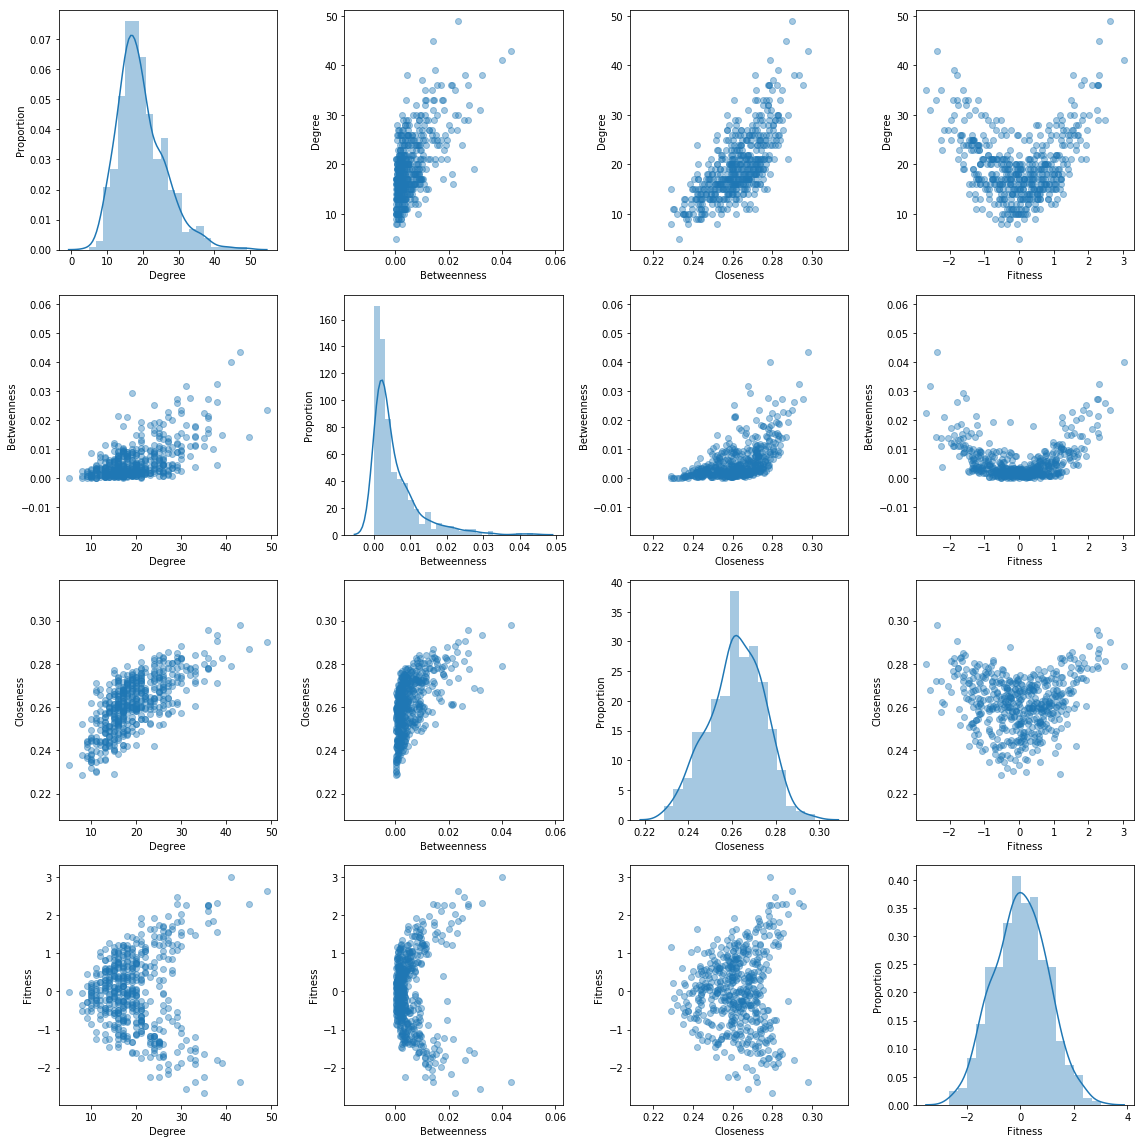

In [152]:
centralities = plot_centrality_correlation(g)

In [142]:
close = nx.closeness_centrality(g)

In [116]:
a = {'a': 5, 'b': 6}
for i, k in enumerate(a):
    print(i)
    print(k)

0
a
1
b


In [143]:
close

{0: 0.24617661568820917,
 1: 0.2655667908461948,
 2: 0.243771372740596,
 3: 0.27614831211953517,
 4: 0.2713431212615552,
 5: 0.26727370112479915,
 6: 0.2681354110693176,
 7: 0.24258629071463297,
 8: 0.2710483432916893,
 9: 0.27599557522123896,
 10: 0.2726775956284153,
 11: 0.25563524590163933,
 12: 0.2613933996856993,
 13: 0.2677038626609442,
 14: 0.25734914904589995,
 15: 0.27119565217391306,
 16: 0.28176171654432525,
 17: 0.27237991266375544,
 18: 0.25922077922077924,
 19: 0.25681935151827073,
 20: 0.2682795698924731,
 21: 0.26655982905982906,
 22: 0.2731253420908593,
 23: 0.26153039832285113,
 24: 0.25498211548288197,
 25: 0.2671306209850107,
 26: 0.2566872427983539,
 27: 0.23317757009345794,
 28: 0.26741693461950694,
 29: 0.2641609317098994,
 30: 0.2758430071862908,
 31: 0.24223300970873787,
 32: 0.26346356916578667,
 33: 0.24025036109773712,
 34: 0.262493424513414,
 35: 0.2607105538140021,
 36: 0.2827195467422096,
 37: 0.2636027469624934,
 38: 0.2772222222222222,
 39: 0.2390991854